In [1]:
!nvidia-smi
# deterministic 모드 활성화
import os
import torch
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
torch.use_deterministic_algorithms(True)

Wed Aug  6 09:23:31 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        On  |   00000000:65:00.0 Off |                  Off |
| 74%   33C    P8             15W /  450W |   11853MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Model Training

In [2]:
import pandas as pd
import pickle
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
import pickle
import pandas as pd
with open("data/cyp2d6_nested_STCV_split_250727.pkl", "rb") as f:
    (train_df_list, test_df_list) = pickle.load(f)



In [4]:
train_df_list[0]['cl'].std()

1.912204945951418

In [5]:
with open("data/CYP2D6_MT_KIT_ESM3_250624.pkl", "rb") as f:
    allele_features = pickle.load(f)
with open("data/MoleBERT_Substrate_NoPreMoleBERT_KIT_0624.pkl", "rb") as f:
    substrate_features = pickle.load(f)

from src.utils.proj_dataset import MoleculeProteinDataset, MoleculeProteinCollate

from src.proj_model import InteractionModel

In [6]:

import numpy as np
for key in substrate_features.keys():
    mat = substrate_features[key]
    global_emb = np.expand_dims(np.mean(mat, axis = 0), axis=0)
    rev_mat = np.concatenate([global_emb, mat], axis = 0)
    substrate_features[key] = rev_mat

In [7]:
allele_features

{'*1': array([[ 1.0547069 , -1.4404287 ,  0.91990715, ..., -1.5899466 ,
          1.9418132 , -1.5260013 ],
        [ 0.11814488,  0.48241052,  0.21860471, ...,  1.1572773 ,
          0.83054334, -0.839961  ],
        [-0.42900905, -1.323586  ,  0.2802592 , ..., -1.0619283 ,
         -0.2439166 ,  0.3374662 ],
        ...,
        [-0.31299707, -1.1495969 ,  0.19314715, ..., -1.0401504 ,
         -0.38553315,  0.47721303],
        [-0.1899054 , -1.2889016 ,  0.5255466 , ..., -1.2711152 ,
         -0.0319083 ,  0.11407533],
        [ 0.61902744, -0.60029346,  0.6328605 , ..., -0.09231935,
          2.2781324 , -1.5122143 ]], dtype=float32),
 '*10': array([[ 0.90393835, -0.6548745 ,  0.57838243, ..., -0.33276322,
          2.0565543 , -1.5532483 ],
        [ 0.01089484,  0.68340033,  0.25083   , ...,  1.3242545 ,
          0.50918025, -0.7407727 ],
        [-0.14995731, -1.7649901 ,  0.7038571 , ..., -1.4677972 ,
          0.37727422, -0.26608592],
        ...,
        [-0.31158498, -1.1

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold






def assign_category(df_row, test_alleles, test_substrates):
    allele_unseen = df_row['Allele'] in test_alleles
    substrate_unseen = df_row['Substrate'] in test_substrates
    
    if allele_unseen and substrate_unseen:
        return 'both_unseen'
    elif allele_unseen:
        return 'allele_unseen'
    elif substrate_unseen:
        return 'substrate_unseen'
    else:
        return 'both_seen'      
        
        
 
        
def random_cv_split(data, n_splits=9, random_state=42):
    """
    Completely random train-test splits without considering allele or substrate structure.
    Compatible with the existing code structure.
    """
    train_dfs = []
    test_dfs = []
    
    # Set random seed for reproducibility
    np.random.seed(random_state)
    
    # Create indices for cross-validation
    indices = np.arange(len(data))


    # 1. target 값을 기반으로 binning (예: 10-quantile)
    data['bins'] = pd.qcut(data['cl'], q=10, labels=False, duplicates='drop')  # duplicates='drop'은 동일 값이 많을 경우 대비
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    for i, (train_idx, test_idx) in enumerate(skf.split(data, data['bins'])):
        # Create train and test sets
        train_df = data.iloc[train_idx].reset_index(drop=True)
        test_df = data.iloc[test_idx].reset_index(drop=True)
        
        # Identify which alleles and substrates are in the test set
        test_alleles = test_df['Allele'].unique().tolist()
        test_substrates = test_df['Substrate'].unique().tolist()
        

        
        train_dfs.append(train_df)
        test_dfs.append(test_df)
    
    return train_dfs, test_dfs    


In [14]:
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, ReduceLROnPlateau
import numpy as np
import os
import time
from copy import deepcopy
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import r2_score, mean_squared_error
from bayes_opt import BayesianOptimization
from functools import partial
import json
from src.utils.training_utils import set_seed
import glob

import torch
import torch.nn as nn
import numpy as np
import os
from copy import deepcopy
from torch.optim.swa_utils import AveragedModel, update_bn
from sklearn.metrics import r2_score, mean_squared_error
from scipy import stats


def evaluate(model, loader, criterion, device='cuda'):
    model.eval()
    losses, preds, trues = [], [], []
    with torch.no_grad():
        for batch in loader:
            alleles = batch['alleles'].to(device)
            substrates = batch['substrates'].to(device)
            allele_masks = batch['allele_masks'].to(device)
            substrate_masks = batch['substrate_masks'].to(device)
            values = batch['values'].to(device)

            gamma, *_ = model(alleles, substrates, allele_masks, substrate_masks)
            loss = criterion(gamma.flatten(), values.flatten())
            losses.append(loss.item())

            p = gamma.cpu().numpy().flatten()
            t = values.cpu().numpy().flatten()
            mask = ~(np.isnan(p) | np.isnan(t))
            preds.append(p[mask])
            trues.append(t[mask])

    preds = np.concatenate(preds) if preds else np.array([])
    trues = np.concatenate(trues) if trues else np.array([])
    r2 = r2_score(trues, preds) if len(trues) > 1 else float('nan')
    rmse = np.sqrt(mean_squared_error(trues, preds)) if len(trues) > 0 else float('nan')
    pearson_r = stats.pearsonr(trues, preds)[0] if len(trues) > 1 else float('nan')
    spearman_r = stats.spearmanr(trues, preds)[0] if len(trues) > 1 else float('nan')
    corr_avg = (pearson_r + spearman_r) / 2.0
    return {
        'loss': float(np.mean(losses)),
        'r2': r2,
        'rmse': rmse,
        'pearson_r': pearson_r,
        'spearman_r': spearman_r,
        'corr_avg': corr_avg
    }

def select_diverse_models(candidates, k=10, min_epoch_gap=5):
    """
    candidates: list of (metric, epoch, state_dict), sorted by metric desc
    returns: top-K models satisfying epoch gap constraint
    """
    selected = []
    for metric, epoch, state in candidates:
        if all(abs(epoch - sel_epoch) >= min_epoch_gap for _, sel_epoch, _ in selected):
            selected.append((metric, epoch, state))
        if len(selected) == k:
            break
    return selected


from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingWarmRestarts




    
def train_model(
    model,
    train_loader,
    val_loader,
    test_loader,
    num_epochs=410,
    lr=2e-3,
    weight_decay=1e-4,
    scheduler_restart_epochs=25,
    device='cuda',
    fold=0,
    model_path='model_ckpts',
    verbose=True,
    top_k=5
):
    """
    Train the model, keep top_k validation checkpoints, build SWA ensemble,
    and return training history along with SWA ensemble metrics on val and test,
    plus top models' test metrics.

    Returns:
        train_hist, val_hist,
        swa_state, swa_val_metrics, swa_test_metrics,
        top_test_results (list of dict with epoch and metrics)
    """
    os.makedirs(model_path, exist_ok=True)
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    steps = len(train_loader)
    T_0 = int(steps * scheduler_restart_epochs)
    # scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    #     optimizer, T_0=T_0, T_mult=1, eta_min=1e-5
    # )
    warmup_steps = steps * 10  # 예: 500 step
    # 1. Linear warmup scheduler
    warmup_scheduler = LinearLR(optimizer, start_factor=1e-7/lr, end_factor=1.0, total_iters=warmup_steps)
    
    # 2. CosineAnnealingWarmRestarts
    cosine_scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=T_0, T_mult=1, eta_min=1e-7)
    
    # 3. Sequential scheduler 조합
    scheduler = SequentialLR(
        optimizer,
        schedulers=[warmup_scheduler, cosine_scheduler],
        milestones=[warmup_steps]
    )
    count = 0
    flag = 0
    train_hist, val_hist = [], []
    top_models = []  # list of (corr_avg, epoch, state_dict)
    #ema = EMA(model, beta=0.95)
    for epoch in range(num_epochs):
        # if epoch > 0:
        #     ema.restore()
        model.train()
        epoch_loss = 0.0
        for batch in train_loader:
            optimizer.zero_grad()
            alleles = batch['alleles'].to(device)
            substrates = batch['substrates'].to(device)
            allele_masks = batch['allele_masks'].to(device)
            substrate_masks = batch['substrate_masks'].to(device)
            values = batch['values'].to(device)

            gamma, *_ = model(alleles, substrates, allele_masks, substrate_masks)
            loss = criterion(gamma.flatten(), values.flatten())
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            #ema.update()
            epoch_loss += loss.item()
        train_hist.append(epoch_loss / len(train_loader))
        
            
        #ema.apply_shadow()
        val_metrics = evaluate(model, val_loader, criterion, device)
        val_hist.append(val_metrics['loss'])
        if verbose and ((epoch + 1) % scheduler_restart_epochs == 0 or epoch == num_epochs - 1):
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_hist[-1]:.4f}, "
                  f"Val r2: {val_metrics['r2']:.4f}, CorrAvg: {val_metrics['corr_avg']:.4f}")
            
        if epoch >= 110:
            metric = val_metrics['r2'] + val_metrics['corr_avg'] - val_metrics['rmse']
            # collect top_k models by metric
            top_models.append((metric, epoch, deepcopy(model.state_dict())))
            top_models = sorted(top_models, key=lambda x: x[0], reverse=True)[:top_k]  # ← top_k 파라미터 사용
            


    # evaluate top_k models on test
    top_test_results = []
    if verbose:
        print("\n=== Top-K Models: Test Performance ===")
    for corr, ep, state in top_models:
        model.load_state_dict(state)
        test_metrics = evaluate(model, val_loader, criterion, device)
        top_test_results.append({'epoch': ep, **test_metrics})
        if verbose:
            print(f"Epoch {ep}: Test CorrAvg={test_metrics['corr_avg']:.4f}, R2={test_metrics['r2']:.4f}, RMSE={test_metrics['rmse']:.4f}")

    # build SWA from top_k
    swa_model = AveragedModel(model)
    for _, _, state in top_models:
        tmp = deepcopy(model)
        tmp.load_state_dict(state)
        swa_model.update_parameters(tmp)
    #update_bn(train_loader, swa_model, device=device)


    swa_test_metrics = evaluate(swa_model, val_loader, criterion, device)
    swa_state = swa_model.module.state_dict() if hasattr(swa_model, 'module') else swa_model.state_dict()

    # # save SWA model
    # swa_path = f"{model_path}/swa_model_fold{fold}.pth"
    # torch.save(swa_state, swa_path)
    # if verbose:
    #     print(f"Saved SWA model with Val CorrAvg={swa_val_metrics['corr_avg']:.4f}, "
    #           f"Test CorrAvg={swa_test_metrics['corr_avg']:.4f} at {swa_path}")

    return train_hist, val_hist, swa_state, swa_test_metrics


In [16]:
def custom_cross_validation(learning_rate,
                           train_df, test_df, allele_features, substrate_features, 
                           model_class, model_params, device, split,  
                           output_dir='custom_cv_models',
                           k_folds=7, num_epochs=300, seed=42):
    """
    사용자 지정 하이퍼파라미터를 사용하여 k-fold 교차 검증을 수행하고    테스트 세트에서 앙상블 모델의 성능을 평가합니다.
    
    Args:
        learning_rate (float): 학습률
        train_df (DataFrame): 학습 데이터
        test_df (DataFrame): 테스트 데이터
        allele_features (dict): allele 특성
        substrate_features (dict): substrate 특성
        model_class: 모델 클래스
        model_params (dict): 모델 파라미터
        device (str): 학습에 사용할 디바이스 ('cuda' 또는 'cpu')
        output_dir (str): 모델 저장 디렉토리
        k_folds (int): fold 수
        num_epochs (int): 에폭 수
        seed (int): 랜덤 시드
        
    Returns:
        dict: 교차 검증 및 테스트 결과
    """
    
    
    
    # 모델 파라미터 업데이트
    updated_model_params = deepcopy(model_params)
    
    
    # 학습 데이터의 인덱스 준비
    train_indices = np.arange(len(train_df))
    
    fold_r2_scores = []
    fold_rmse_scores = []
    fold_pearson_r_scores = []
    fold_spearman_r_scores = []  # Spearman 상관계수 저장 리스트 추가
    fold_corr_avg_scores = []    # Pearson과 Spearman의 평균 저장 리스트 추가
    best_model_states = []       # 각 fold의 최상 모델 상태 저장
    
    # 저장 디렉토리 생성
    save_dir = output_dir
    os.makedirs(save_dir, exist_ok=True)
    
    # 각 fold에 대해 학습 수행
    print(f"Starting {k_folds}-fold cross validation")
    print("=" * 70)
    fold_train_dfs, fold_val_dfs = random_cv_split(train_df, n_splits=k_folds)
    
    #max_epochs = [400, 700, 700, 100, 400, 700, 100, 500, 800, 200]
    for fold in range(k_folds):
        # if fold != 5:
        #     continue
        set_seed(seed)
        
        print(f"Fold {fold+1}/{k_folds}")
        fold_train_df = fold_train_dfs[fold].reset_index(drop=True)
        fold_val_df = fold_val_dfs[fold].reset_index(drop=True)

       
        # 데이터셋 생성
        train_dataset = MoleculeProteinDataset(
            allele_features=allele_features,
            substrate_features=substrate_features,
            df=fold_train_df, 
            label_name='cl'
        )
        
        val_dataset = MoleculeProteinDataset(
            allele_features=allele_features,
            substrate_features=substrate_features,
            df=fold_val_df, 
            label_name='cl'
        )

        test_dataset = MoleculeProteinDataset(
            allele_features=allele_features,
            substrate_features=substrate_features,
            df=test_df, 
            label_name='cl'
        )
        # samples_weight = fold_train_df['z_score'].values
        # samples_weight = torch.from_numpy(samples_weight)
        # sampler = torch.utils.data.WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))
        
        # # 데이터 로더 생성
        # train_loader = DataLoader(
        #     train_dataset,
        #     batch_size=model_params.get('batch_size', 32),
        #     #shuffle=True,
        #     drop_last=True,
        #     collate_fn=MoleculeProteinCollate,
        #     sampler = sampler
        # )
        # 데이터 로더 생성
        train_loader = DataLoader(
            train_dataset,
            batch_size=model_params.get('batch_size', 32),
            shuffle=True,
            drop_last=True,
            collate_fn=MoleculeProteinCollate
        )
        
        val_loader = DataLoader(
            val_dataset,
            batch_size=model_params.get('batch_size', 32),
            shuffle=False,
            collate_fn=MoleculeProteinCollate
        )

        test_loader = DataLoader(
            test_dataset,
            batch_size=model_params.get('batch_size', 32),
            shuffle=False,
            collate_fn=MoleculeProteinCollate
        )
        
        # 모델 초기화
        model = model_class(**updated_model_params)
        model = model.to(device)
        
        # 임시 모델 경로
        temp_model_path = f'{output_dir}_temp'
        
        # 모델 학습
        _, _, best_model_state, best_val_metrics = train_model(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            test_loader = test_loader,
            num_epochs=num_epochs,
            lr=learning_rate,
            weight_decay=model_params.get('weight_decay', 1e-4),
            scheduler_restart_epochs=model_params.get('restart_epochs',25),
            device=device,
            fold=fold,
            model_path=temp_model_path,
            verbose=False
        )
        
        #print(best_val_metrics['epoch'])
        
        best_model_states.append(best_model_state)
        
        # R² 점수 처리
        r2_value = best_val_metrics['r2']
        rmse_value = best_val_metrics['rmse']
        pearson_r_value = best_val_metrics['pearson_r']
        spearman_r_value = best_val_metrics['spearman_r']  # Spearman r 값 가져오기
        corr_avg_value = (pearson_r_value + spearman_r_value) / 2.0 #best_val_metrics['corr_avg']      # 상관계수 평균 값 가져오기
        
       
        fold_r2_scores.append(r2_value)
            
        fold_rmse_scores.append(rmse_value)
            
        fold_pearson_r_scores.append(pearson_r_value)
        
        fold_spearman_r_scores.append(spearman_r_value)
        
        fold_corr_avg_scores.append(corr_avg_value)
            
        # 각 fold의 결과 출력
        print(f"  Fold {fold+1} - R²: {r2_value:.4f}, RMSE: {rmse_value:.4f}, PearsonR: {pearson_r_value:.4f}, SpearmanR: {spearman_r_value:.4f}, CorrAvg: {corr_avg_value:.4f}")

    
    # CV 평균 성능 계산
    if len(fold_r2_scores) == 0:
        mean_r2 = 0.0
        mean_rmse = float('inf')
        mean_pearson_r = 0.0
        mean_spearman_r = 0.0  # Spearman 평균 추가
        mean_corr_avg = 0.0    # 상관계수 평균의 평균 추가
    else:
        mean_r2 = np.mean(fold_r2_scores)
        valid_rmse = [score for score in fold_rmse_scores if not np.isinf(score)]
        mean_rmse = np.mean(valid_rmse) if valid_rmse else float('inf')
        mean_pearson_r = np.mean(fold_pearson_r_scores)
        mean_spearman_r = np.mean(fold_spearman_r_scores)  # Spearman 평균 계산
        mean_corr_avg = np.mean(fold_corr_avg_scores)      # 상관계수 평균의 평균 계산
    
    # NaN 점수 처리
    if np.isnan(mean_r2):
        mean_r2 = 0.0
    if np.isnan(mean_spearman_r):
        mean_spearman_r = 0.0
    if np.isnan(mean_corr_avg):
        mean_corr_avg = 0.0
    
    print("=" * 70)
    print(f"Cross-validation results")
    print(f"Mean R² across {k_folds} folds: {mean_r2:.4f}")
    print(f"Mean RMSE across {k_folds} folds: {mean_rmse:.4f}")
    print(f"Mean Pearson r across {k_folds} folds: {mean_pearson_r:.4f}")
    print(f"Mean Spearman r across {k_folds} folds: {mean_spearman_r:.4f}")  # Spearman 결과 출력
    print(f"Mean Correlation Avg across {k_folds} folds: {mean_corr_avg:.4f}")  # 상관계수 평균 결과 출력
    print("=" * 70)
    
    # 고유 식별자 생성 (상관계수 평균 기준으로 변경)
    param_id = f"corr_avg_{mean_corr_avg:.4f}"
    
    # 모델 저장
    for fold, state_dict in enumerate(best_model_states):
        torch.save(state_dict, f'{save_dir}/fold_{fold}_{param_id}.pth')
    
    # 파라미터 정보 저장 (NumPy 타입을 Python 내장 타입으로 변환)
    param_info = {
        'mean_r2': float(mean_r2),
        'mean_rmse': float(mean_rmse),
        'mean_pearson_r': float(mean_pearson_r),
        'mean_spearman_r': float(mean_spearman_r),  # Spearman 평균 추가
        'mean_corr_avg': float(mean_corr_avg),      # 상관계수 평균의 평균 추가
        'fold_r2_scores': [float(x) for x in fold_r2_scores],
        'fold_rmse_scores': [float(x) if not np.isinf(x) else "Infinity" for x in fold_rmse_scores],
        'fold_pearson_r_scores': [float(x) for x in fold_pearson_r_scores],
        'fold_spearman_r_scores': [float(x) for x in fold_spearman_r_scores],  # Spearman 점수 리스트 추가
        'fold_corr_avg_scores': [float(x) for x in fold_corr_avg_scores],      # 상관계수 평균 리스트 추가
        'param_id': param_id
    }
    
    with open(f'{save_dir}/params_{param_id}.json', 'w') as f:
        json.dump(param_info, f, indent=4)
    
    print("Cross-validation models saved.")
    
    print("\n=== 테스트 세트 평가 시작 ===")
    print("-" * 70)
    
    # 테스트 세트에서 앙상블 평가
    test_results, all_fold_predictions = evaluate_ensemble_on_test(
        test_df=test_df,
        allele_features=allele_features,
        substrate_features=substrate_features,
        model_class=model_class,
        model_params=updated_model_params,
        model_states=best_model_states,
        device=device
    )
    
    return best_model_states, all_fold_predictions, test_results


def evaluate_ensemble_on_test(test_df, allele_features, substrate_features, 
                             model_class, model_params, model_states, device):
    """
    학습된 앙상블 모델의 테스트 세트 성능을 평가합니다.
    
    Args:
        test_df (DataFrame): 테스트 데이터
        allele_features (dict): allele 특성
        substrate_features (dict): substrate 특성
        model_class: 모델 클래스
        model_params (dict): 모델 파라미터
        model_states (list): 각 fold의 모델 상태 목록
        device (str): 평가에 사용할 디바이스
        
    Returns:
        dict: 테스트 평가 결과
    """
    print("Evaluating ensemble model on test set...")
    
    # 테스트 데이터셋 생성
    test_dataset = MoleculeProteinDataset(
        allele_features=allele_features,
        substrate_features=substrate_features,
        df=test_df, 
        label_name='cl'
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=model_params.get('batch_size', 32),
        shuffle=False,
        collate_fn=MoleculeProteinCollate
    )
    
    # 타겟값 먼저 수집 (테스트셋은 항상 동일)
    targets = []
    with torch.no_grad():
        for batch in test_loader:
            values = batch['values'].cpu().numpy()
            targets.extend(values)
    
    all_targets = np.array(targets).flatten()
    
    # 각 fold 모델의 예측 수집
    all_fold_predictions = []
    
    for fold, state_dict in enumerate(model_states):
        model = model_class(**model_params)
        model.load_state_dict(state_dict)
        model = model.to(device)
        model.eval()
        
        fold_predictions = []
        
        with torch.no_grad():
            for batch in test_loader:
                alleles = batch['alleles'].to(device)
                substrates = batch['substrates'].to(device)
                allele_masks = batch['allele_masks'].to(device)
                substrate_masks = batch['substrate_masks'].to(device)
                
                # 모델이 EvidentialNet인 경우, gamma가 예측값
                gamma, _, _, _ = model(alleles, substrates, allele_masks, substrate_masks)
                predictions = gamma.cpu().numpy()
                fold_predictions.extend(predictions)
        
        all_fold_predictions.append(np.array(fold_predictions).flatten())
    
    # 앙상블 예측 (모든 fold의 평균)
    ensemble_predictions = np.mean(all_fold_predictions, axis=0)
    
    # 크기 확인 및 문제 발생 시 디버깅 정보 출력
    if len(ensemble_predictions) != len(all_targets):
        print(f"경고: 예측값 크기({len(ensemble_predictions)})와 타겟값 크기({len(all_targets)})가 일치하지 않습니다.")
        min_length = min(len(ensemble_predictions), len(all_targets))
        print(f"최소 길이({min_length})로 배열을 자릅니다.")
        ensemble_predictions = ensemble_predictions[:min_length]
        all_targets = all_targets[:min_length]
    
    # NaN 값 처리
    valid_indices = ~(np.isnan(ensemble_predictions) | np.isnan(all_targets))
    
    if np.sum(valid_indices) != len(all_targets):
        print("경고: 테스트 예측에 NaN 값이 있습니다.")
        test_results = {
            'r2': 0.0,
            'rmse': float('inf'),
            'pearson_r': 0.0,
            'pearson_p': 1.0,
            'spearman_r': 0.0,  # Spearman 관련 기본값 추가
            'spearman_p': 1.0,
            'corr_avg': 0.0     # 상관계수 평균 기본값 추가
        }
    else:
        # 유효한 예측값만 사용하여 성능 평가
        filtered_predictions = ensemble_predictions[valid_indices]
        filtered_targets = all_targets[valid_indices]
        
        # 상수 배열 처리
        if np.all(filtered_predictions == filtered_predictions[0]) or np.all(filtered_targets == filtered_targets[0]):
            test_results = {
                'r2': 0.0,
                'rmse': np.sqrt(mean_squared_error(filtered_targets, filtered_predictions)),
                'pearson_r': 0.0,
                'pearson_p': 1.0,
                'spearman_r': 0.0,  # Spearman 관련 기본값 추가
                'spearman_p': 1.0,
                'corr_avg': 0.0     # 상관계수 평균 기본값 추가
            }
        else:
            try:
                r2 = r2_score(filtered_targets, filtered_predictions)
                rmse = np.sqrt(mean_squared_error(filtered_targets, filtered_predictions))
                pearson_r, pearson_p = stats.pearsonr(filtered_targets, filtered_predictions)
                spearman_r, spearman_p = stats.spearmanr(filtered_targets, filtered_predictions)  # Spearman 상관계수 계산
                corr_avg = (pearson_r + spearman_r) / 2.0  # 상관계수 평균 계산
                
                test_results = {
                    'r2': float(r2),
                    'rmse': float(rmse),
                    'pearson_r': float(pearson_r),
                    'pearson_p': float(pearson_p),
                    'spearman_r': float(spearman_r),  # Spearman 관련 결과 추가
                    'spearman_p': float(spearman_p),
                    'corr_avg': float(corr_avg)       # 상관계수 평균 추가
                }
            except Exception as e:
                print(f"테스트 메트릭 계산 중 오류 발생: {str(e)}")
                test_results = {
                    'r2': 0.0,
                    'rmse': float('inf'),
                    'pearson_r': 0.0,
                    'pearson_p': 1.0,
                    'spearman_r': 0.0,  # Spearman 관련 기본값 추가
                    'spearman_p': 1.0,
                    'corr_avg': 0.0     # 상관계수 평균 기본값 추가
                }
    
    # 앙상블 테스트 결과 출력
    print("\n=== 앙상블 모델의 테스트 세트 성능 ===")
    print("-" * 70)
    if np.isinf(test_results['rmse']):
        rmse_str = "inf"
    else:
        rmse_str = f"{test_results['rmse']:.4f}"
        
    print(f"앙상블 R²       : {test_results['r2']:.4f}")
    print(f"앙상블 RMSE     : {rmse_str}")
    print(f"앙상블 Pearson r: {test_results['pearson_r']:.4f}")
    print(f"앙상블 Spearman r: {test_results['spearman_r']:.4f}")  # Spearman 결과 출력
    print(f"앙상블 Corr Avg : {test_results['corr_avg']:.4f}")     # 상관계수 평균 결과 출력
    print("-" * 70)
    
    # 개별 fold의 테스트 성능도 계산
    individual_fold_results = []
    
    print("\n=== 각 Fold별 테스트 세트 성능 ===")
    print("-" * 70)
    print("| Fold  |   R²   |  RMSE  | Pearson r | Spearman r | Corr Avg |")  # 테이블 헤더 수정
    print("|-------|--------|--------|-----------|------------|----------|")   # 테이블 구분선 수정
    
    for fold, fold_preds in enumerate(all_fold_predictions):
        valid_indices = ~(np.isnan(fold_preds) | np.isnan(all_targets))
        
        if np.sum(valid_indices) < 2:
            fold_result = {
                'fold': fold,
                'r2': 0.0,
                'rmse': float('inf'),
                'pearson_r': 0.0,
                'pearson_p': 1.0,
                'spearman_r': 0.0,  # Spearman 관련 기본값 추가
                'spearman_p': 1.0,
                'corr_avg': 0.0     # 상관계수 평균 기본값 추가
            }
        else:
            filtered_preds = fold_preds[valid_indices]
            filtered_targets = all_targets[valid_indices]
            
            try:
                fold_r2 = r2_score(filtered_targets, filtered_preds)
                fold_rmse = np.sqrt(mean_squared_error(filtered_targets, filtered_preds))
                fold_pearson_r, fold_pearson_p = stats.pearsonr(filtered_targets, filtered_preds)
                fold_spearman_r, fold_spearman_p = stats.spearmanr(filtered_targets, filtered_preds)  # Spearman 상관계수 계산
                fold_corr_avg = (fold_pearson_r + fold_spearman_r) / 2.0  # 상관계수 평균 계산
                
                fold_result = {
                    'fold': fold,
                    'r2': float(fold_r2),
                    'rmse': float(fold_rmse),
                    'pearson_r': float(fold_pearson_r),
                    'pearson_p': float(fold_pearson_p),
                    'spearman_r': float(fold_spearman_r),  # Spearman 관련 결과 추가
                    'spearman_p': float(fold_spearman_p),
                    'corr_avg': float(fold_corr_avg)       # 상관계수 평균 추가
                }
            except Exception as e:
                print(f"  경고: Fold {fold}의 메트릭 계산 중 오류 발생: {str(e)}")
                fold_result = {
                    'fold': fold,
                    'r2': 0.0,
                    'rmse': float('inf'),
                    'pearson_r': 0.0,
                    'pearson_p': 1.0,
                    'spearman_r': 0.0,  # Spearman 관련 기본값 추가
                    'spearman_p': 1.0,
                    'corr_avg': 0.0     # 상관계수 평균 기본값 추가
                }
        
        individual_fold_results.append(fold_result)
        
        # 테이블 형식으로 출력 (Spearman과 상관계수 평균 추가)
        if np.isinf(fold_result['rmse']):
            rmse_str = "  inf  "
        else:
            rmse_str = f"{fold_result['rmse']:.4f}"
            
        print(f"| {fold:^5} | {fold_result['r2']:^6.4f} | {rmse_str} | {fold_result['pearson_r']:^9.4f} | {fold_result['spearman_r']:^10.4f} | {fold_result['corr_avg']:^8.4f} |")
    
    # 개별 fold들과 앙상블 성능 비교 출력
    fold_r2_values = [res['r2'] for res in individual_fold_results]
    fold_rmse_values = [res['rmse'] for res in individual_fold_results if not np.isinf(res['rmse'])]
    fold_pearson_values = [res['pearson_r'] for res in individual_fold_results]
    fold_spearman_values = [res['spearman_r'] for res in individual_fold_results]  # Spearman 값 리스트 추가
    fold_corr_avg_values = [res['corr_avg'] for res in individual_fold_results]    # 상관계수 평균 값 리스트 추가
    
    print("\n=== 테스트 세트 성능 요약 ===")
    print("-" * 70)
    print(f"개별 Fold 평균 R²       : {np.mean(fold_r2_values):.4f}")
    print(f"개별 Fold 최고 R²       : {np.max(fold_r2_values):.4f} (Fold {np.argmax(fold_r2_values)})")
    
    if fold_rmse_values:
        print(f"개별 Fold 평균 RMSE     : {np.mean(fold_rmse_values):.4f}")
        print(f"개별 Fold 최저 RMSE     : {np.min(fold_rmse_values):.4f}")
    
    print(f"개별 Fold 평균 Pearson r: {np.mean(fold_pearson_values):.4f}")
    print(f"개별 Fold 최고 Pearson r: {np.max(fold_pearson_values):.4f} (Fold {np.argmax(fold_pearson_values)})")
    
    # Spearman과 상관계수 평균 결과 추가
    print(f"개별 Fold 평균 Spearman r: {np.mean(fold_spearman_values):.4f}")
    print(f"개별 Fold 최고 Spearman r: {np.max(fold_spearman_values):.4f} (Fold {np.argmax(fold_spearman_values)})")
    print(f"개별 Fold 평균 Corr Avg  : {np.mean(fold_corr_avg_values):.4f}")
    print(f"개별 Fold 최고 Corr Avg  : {np.max(fold_corr_avg_values):.4f} (Fold {np.argmax(fold_corr_avg_values)})")
    
    print("-" * 70)
    print(f"앙상블 모델 R² (참고)   : {test_results['r2']:.4f}")
    print(f"앙상블 모델 Corr Avg    : {test_results['corr_avg']:.4f}")  # 앙상블 모델의 상관계수 평균 추가
    print("-" * 70)
    
    # 테스트 결과 반환
    test_summary = {
        'ensemble': test_results,
        'individual_folds': individual_fold_results,
        'summary': {
            'avg_fold_r2': float(np.mean(fold_r2_values)),
            'max_fold_r2': float(np.max(fold_r2_values)),
            'best_fold_idx_r2': int(np.argmax(fold_r2_values)),
            'avg_fold_pearson_r': float(np.mean(fold_pearson_values)),
            'max_fold_pearson_r': float(np.max(fold_pearson_values)),
            'best_fold_idx_pearson': int(np.argmax(fold_pearson_values)),
            # Spearman과 상관계수 평균 요약 정보 추가
            'avg_fold_spearman_r': float(np.mean(fold_spearman_values)),
            'max_fold_spearman_r': float(np.max(fold_spearman_values)),
            'best_fold_idx_spearman': int(np.argmax(fold_spearman_values)),
            'avg_fold_corr_avg': float(np.mean(fold_corr_avg_values)),
            'max_fold_corr_avg': float(np.max(fold_corr_avg_values)),
            'best_fold_idx_corr_avg': int(np.argmax(fold_corr_avg_values))
        }
    }
    
    # fold_rmse_values가 비어있지 않은 경우에만 추가
    if fold_rmse_values:
        test_summary['summary']['avg_fold_rmse'] = float(np.mean(fold_rmse_values))
        test_summary['summary']['min_fold_rmse'] = float(np.min(fold_rmse_values))
    
    return test_summary, all_fold_predictions

In [17]:
##### 사용 예시
lr = 0.002 # 사용자 지정 학습률
dropout_rate = 0.1
# 모델 파라미터 설정
model_params = {
    'mol_input_dim': 300,
    'prot_input_dim': 300,
    'hidden_dim': 64,  # Default value, will be updated during optimization
    'num_heads': 1,
    'drop_out': dropout_rate   # Will be overridden by unified dropout rate
}


# 교차 검증 및 테스트 실행
results_list = []
for i in range(10):
    # if i != 3:
    #     continue
    results = custom_cross_validation(
        learning_rate=lr,
        train_df=train_df_list[i],
        test_df=test_df_list[i],
        allele_features=allele_features,
        substrate_features=substrate_features,
        model_class=InteractionModel,  # 모델 클래스
        model_params=model_params,
        device='cuda' if torch.cuda.is_available() else 'cpu',
        output_dir='der_cv_models',
        k_folds=9,
        num_epochs=410,
        seed=42,
        split = i
    )
    results_list.append(results)


Starting 9-fold cross validation
Fold 1/9
  Fold 1 - R²: 0.7527, RMSE: 1.1382, PearsonR: 0.8682, SpearmanR: 0.8010, CorrAvg: 0.8346
Fold 2/9
  Fold 2 - R²: 0.5650, RMSE: 1.2575, PearsonR: 0.7836, SpearmanR: 0.7665, CorrAvg: 0.7750
Fold 3/9
  Fold 3 - R²: 0.7731, RMSE: 0.9785, PearsonR: 0.8804, SpearmanR: 0.8522, CorrAvg: 0.8663
Fold 4/9
  Fold 4 - R²: 0.7522, RMSE: 0.8661, PearsonR: 0.8810, SpearmanR: 0.8788, CorrAvg: 0.8799
Fold 5/9
  Fold 5 - R²: 0.7941, RMSE: 0.8364, PearsonR: 0.8956, SpearmanR: 0.8557, CorrAvg: 0.8756
Fold 6/9
  Fold 6 - R²: 0.6951, RMSE: 1.0647, PearsonR: 0.8365, SpearmanR: 0.8054, CorrAvg: 0.8210
Fold 7/9
  Fold 7 - R²: 0.8213, RMSE: 0.7561, PearsonR: 0.9122, SpearmanR: 0.8916, CorrAvg: 0.9019
Fold 8/9
  Fold 8 - R²: 0.6083, RMSE: 1.1694, PearsonR: 0.7812, SpearmanR: 0.7724, CorrAvg: 0.7768
Fold 9/9
  Fold 9 - R²: 0.7332, RMSE: 0.8686, PearsonR: 0.8672, SpearmanR: 0.8350, CorrAvg: 0.8511
Cross-validation results
Mean R² across 9 folds: 0.7217
Mean RMSE across 9 f

In [ ]:
import numpy as np

In [209]:
val_r2 = []
val_rmse = []
val_p = []
val_s = []
for i in range(10):
    val_r2.append(results_list[i][2]['ensemble']['r2'])
    val_rmse.append(results_list[i][2]['ensemble']['rmse'])
    val_p.append(results_list[i][2]['ensemble']['pearson_r'])
    val_s.append(results_list[i][2]['ensemble']['spearman_r'])
print("Averge Test R2: ", np.mean(val_r2), "±", np.std(val_r2))
print("Averge Test RMSE: ", np.mean(val_rmse), "±", np.std(val_rmse))
print("Averge Test Pearson: ", np.mean(val_p), "±", np.std(val_p))
print("Averge Test Spearman: ", np.mean(val_s), "±", np.std(val_s))
    

Averge Test R2:  0.740744378814883 ± 0.050275434531143214
Averge Test RMSE:  0.962435269355774 ± 0.09960069047338244
Averge Test Pearson:  0.8755895376205445 ± 0.026605668567345156
Averge Test Spearman:  0.845402828539647 ± 0.044293238323725476


In [22]:
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import pickle
import pandas as pd
from src.utils.proj_dataset import MoleculeProteinDataset, MoleculeProteinCollate

from src.proj_model import InteractionModel

with open("data/cyp2d6_nested_STCV_split_250727.pkl", "rb") as f:
    (train_df_list, test_df_list) = pickle.load(f)


with open("data/CYP2D6_MT_KIT_ESM3_250624.pkl", "rb") as f:
    allele_features = pickle.load(f)
with open("data/MoleBERT_Substrate_NoPreMoleBERT_KIT_0624.pkl", "rb") as f:
    substrate_features = pickle.load(f)

for key in substrate_features.keys():
    mat = substrate_features[key]
    global_emb = np.expand_dims(np.mean(mat, axis = 0), axis=0)
    rev_mat = np.concatenate([global_emb, mat], axis = 0)
    substrate_features[key] = rev_mat   


device = 'cuda'
test_df = pd.read_csv("../deep_cyp/data/cyp2d6_final_ours_preprocessed_250408.csv")

model_states = []
dropout_rate = 0.1
model_params = {
    'mol_input_dim': 300,
    'prot_input_dim': 300,
    'hidden_dim': 64,  # Default value, will be updated during optimization
    'num_heads': 1,
    'drop_out': dropout_rate   # Will be overridden by unified dropout rate
}
acc_list = []
f1_list = []
r2_list = []
all_fold_predictions_test = []
for i in range(10):
    

    

    best_r2 = -100
    
    for j in range(9):
        test_dataset = MoleculeProteinDataset(
            allele_features=allele_features,
            substrate_features=substrate_features,
            df=test_df, 
            label_name='cl'
        )
        test_loader = DataLoader(
            test_dataset,
            batch_size=model_params.get('batch_size', 32),
            shuffle=False,
            collate_fn=MoleculeProteinCollate
        )
        model = InteractionModel(**model_params)
        model.load_state_dict(results_list[i][0][j])
        model = model.to(device)
        model.eval()
        
        
        targets = []
        fold_predictions = []
        with torch.no_grad():
            for batch in test_loader:
                alleles = batch['alleles'].to(device)
                substrates = batch['substrates'].to(device)
                allele_masks = batch['allele_masks'].to(device)
                substrate_masks = batch['substrate_masks'].to(device)
                
                # 모델이 EvidentialNet인 경우, gamma가 예측값
                gamma, _, _, _ = model(alleles, substrates, allele_masks, substrate_masks)
                predictions = gamma.cpu().numpy()
                values = batch['values'].cpu().numpy()
                targets.extend(values)
                fold_predictions.extend(predictions)

        r2 = r2_score(np.array(targets).flatten(), np.array(fold_predictions).flatten())
        # if r2 > best_r2:
        #     best_r2 = r2
        #     best_pred_set = np.array(fold_predictions).flatten()
            #print(r2)
        r2_list.append(r2)
        all_fold_predictions_test.append(np.array(fold_predictions).flatten())

        

        # 앙상블 예측 (모든 fold의 평균)
ensemble_predictions_test = np.mean(all_fold_predictions_test, axis=0)
test_df['pred'] = ensemble_predictions_test
# Allele과 Substrate 기준으로 *1에 대한 relative pred 값 계산
# sns.scatterplot(test_df, x='cl', y='pred')
# plt.show()
r2 = r2_score(np.array(targets).flatten(), np.array(fold_predictions).flatten())
print(r2)
    
                
               

0.8679670274623814


In [23]:
# 또는 더 간단하게
def get_top_n_indices_simple(lst, n):
    return np.argsort(lst)[-n:][::-1]

top_indices = get_top_n_indices_simple(r2_list, 90)
print(top_indices)  # [6 2 3]

[28 56 70 29  2 86 39 63 47 84  7 55 42 16 58 66 41 59 24 30 74 88 23 14
 89 85 32 50 31 45 12 40 34  3 22 65 18 37 13 81 71 61 82 73 48 69 54 51
 62 27 52  8 43 64 57 79 36 67 10 83 53 60 33 75  5  6 76 77  1 68 20 72
  9  0 11 17 19 38 49 35 26 46 80 15 87 78 44 25  4 21]


In [24]:
model_states = []
for i in range(10):
    for j in range(9):
        if (i * 9 + j) in top_indices:
            model_states.append(results_list[i][0][j])

In [25]:
import pickle
with open("data/cyp_top10_models_ckpts.pkl", "wb") as f:
    pickle.dump(model_states, f)

In [1237]:
import pandas as pd


test_df = pd.read_csv("data/cyp2d6_final_293ft_external_0808.csv")
test_df['cl_rev'] = test_df['cl'].map(lambda x: np.log1p(x))

with open("data/CYP2D6_external_public_293FT_ESM3_0807.pkl", "rb") as f:
    allele_features = pickle.load(f)
with open("data/MoleBERT_Substrate_NoPreMoleBERT_External_250602.pkl", "rb") as f:
    substrate_features = pickle.load(f)

for key in substrate_features.keys():
    mat = substrate_features[key]
    global_emb = np.expand_dims(np.mean(mat, axis = 0), axis=0)
    rev_mat = np.concatenate([global_emb, mat], axis = 0)
    substrate_features[key] = rev_mat    

model_states = []
for i in range(10):
    for j in range(9):
        model_states.append(results_list[i][0][j])

from src.utils.proj_dataset import MoleculeProteinDataset, MoleculeProteinCollate

from src.proj_model import InteractionModel



dropout_rate = 0.1
model_params = {
    'mol_input_dim': 300,
    'prot_input_dim': 300,
    'hidden_dim': 64,  # Default value, will be updated during optimization
    'num_heads': 1,
    'drop_out': dropout_rate   # Will be overridden by unified dropout rate
}
device = 'cuda'

# 테스트 데이터셋 생성
test_dataset = MoleculeProteinDataset(
    allele_features=allele_features,
    substrate_features=substrate_features,
    df=test_df, 
    label_name='cl_rev'
)

test_loader = DataLoader(
    test_dataset,
    batch_size=model_params.get('batch_size', 32),
    shuffle=False,
    collate_fn=MoleculeProteinCollate
)

# 타겟값 먼저 수집 (테스트셋은 항상 동일)
targets = []
with torch.no_grad():
    for batch in test_loader:
        values = batch['values'].cpu().numpy()
        targets.extend(values)

all_targets = np.array(targets).flatten()

# 각 fold 모델의 예측 수집
all_fold_predictions = []

for fold, state_dict in enumerate(model_states):
    model = InteractionModel(**model_params)
    model.load_state_dict(state_dict)
    model = model.to(device)
    model.eval()
    
    fold_predictions = []
    
    with torch.no_grad():
        for batch in test_loader:
            alleles = batch['alleles'].to(device)
            substrates = batch['substrates'].to(device)
            allele_masks = batch['allele_masks'].to(device)
            substrate_masks = batch['substrate_masks'].to(device)
            
            # 모델이 EvidentialNet인 경우, gamma가 예측값
            gamma, _, _, _ = model(alleles, substrates, allele_masks, substrate_masks)
            predictions = gamma.cpu().numpy()
            fold_predictions.extend(predictions)
    
    all_fold_predictions.append(np.array(fold_predictions).flatten())
# 앙상블 예측 (모든 fold의 평균)
ensemble_predictions = np.mean(all_fold_predictions, axis=0)
test_df['log_pred'] = ensemble_predictions

In [1240]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr, kendalltau

# 파라미터
WT_NAME = 'cyp2d6*1'

# 1) WT 인덱스(약물별) 만들기
wt_rows = test_df[test_df['Allele'] == WT_NAME].copy()
if wt_rows.empty:
    raise ValueError("WT 행이 없습니다. WT_NAME을 확인하세요.")

# 관측/예측의 WT 맵(로그, z)
wt_log_obs = wt_rows.set_index('Substrate')['cl_rev'].to_dict()
wt_log_pred = wt_rows.set_index('Substrate')['log_pred'].to_dict()


# 2) 각 행에 대해 RC 계산 (WT 자신은 NaN 처리)
def safe_diff(val, anchor):
    try:
        return val - anchor
    except KeyError:
        return np.nan

test_df['RC_log_obs']  = test_df.apply(lambda r: safe_diff(r['cl_rev'],   wt_log_obs.get(r['Substrate'], np.nan)), axis=1)
test_df['RC_log_pred'] = test_df.apply(lambda r: safe_diff(r['log_pred'], wt_log_pred.get(r['Substrate'], np.nan)), axis=1)



# 3) (선택) 배수로 역변환
test_df['RC_ratio_obs']  = np.exp(test_df['RC_log_obs'])
test_df['RC_ratio_pred'] = np.exp(test_df['RC_log_pred'])

# 4) 평가 지표 (WT 행 제외)
mask = (test_df['Allele'] != WT_NAME) & test_df[['RC_log_obs','RC_log_pred','RC_ratio_obs','RC_ratio_pred']].notna().all(axis=1)
eval_df = test_df.loc[mask].copy()



In [1251]:
len(eval_df)

23

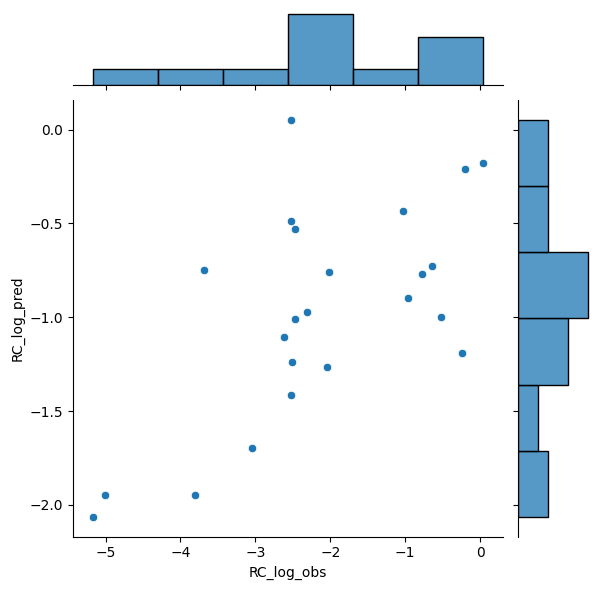

In [1241]:
import seaborn as sns
sns.jointplot(data=eval_df, x = 'RC_log_obs', y='RC_log_pred')

In [1021]:
def calculate_concordance_index(y_true, y_pred):
    """
    Concordance Index (C-index) 계산
    C-index는 모든 쌍에 대해 예측 순서가 실제 순서와 일치하는 비율을 측정
    
    Parameters:
    y_true: 실제값
    y_pred: 예측값
    
    Returns:
    float: C-index 값 (0.5 = 랜덤, 1.0 = 완벽한 예측)
    """
    n = len(y_true)
    if n < 2:
        return np.nan
    
    concordant = 0
    total_pairs = 0
    
    for i in range(n):
        for j in range(i + 1, n):
            # 실제 값이 다른 경우만 고려 (동점 제외)
            if y_true[i] != y_true[j]:
                total_pairs += 1
                # 실제 순서와 예측 순서가 일치하면 concordant
                if (y_true[i] < y_true[j] and y_pred[i] < y_pred[j]) or \
                   (y_true[i] > y_true[j] and y_pred[i] > y_pred[j]):
                    concordant += 1
    
    if total_pairs == 0:
        return np.nan
    
    return concordant / total_pairs

In [1242]:
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.metrics import r2_score, mean_squared_error
r2 = r2_score(eval_df['RC_log_obs'], eval_df['RC_log_pred'])
rmse = np.sqrt(mean_squared_error(eval_df['RC_log_obs'], eval_df['RC_log_pred']))

# 상관계수 지표들
pearson_corr, pearson_p = pearsonr(eval_df['RC_log_obs'], eval_df['RC_log_pred'])
spearman_corr, spearman_p = spearmanr(eval_df['RC_log_obs'],eval_df['RC_log_pred'])
c_index = calculate_concordance_index(eval_df['RC_log_obs'].values, eval_df['RC_log_pred'].values)
kendalltau = kendalltau(eval_df['RC_log_obs'], eval_df['RC_log_pred']).correlation
print(c_index, kendalltau)
#kendall_tau, kendall_p = kendalltau(y_true_clean, y_pred_clean)

0.7103174603174603 0.41980280326088576
